# **KLASIFIKASI KATEGORI BERITA BRITISH BROADCASTING CORPORATION (BBC) MENGGUNAKAN METODE RECURRENT NEURAL NETWORK (RNN) DAN NAIVE BAYES CLASSIFIER**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/bbc-text.csv',engine='python')
# df.columns = map(str.lower, df.columns)
df["text"] = df["text"].astype(str)
corpus = df['text'].tolist()
corpus[0][0:447]

print(f"Jumlah dataset: {len(df)}")
print(df.head(10))

Jumlah dataset: 2225
        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...
5       politics  howard hits back at mongrel jibe michael howar...
6       politics  blair prepares to name poll date tony blair is...
7          sport  henman hopes ended in dubai third seed tim hen...
8          sport  wilkinson fit to face edinburgh england captai...
9  entertainment  last star wars  not for children  the sixth an...


**1. Preprocessing**

In [ ]:
!pip install unidecode

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import nltk
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import re
import nltk.corpus
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from pandas import DataFrame

# Preprocessing function with case folding, tokenization, stopword removal, and lemmatization
def processCorpus(corpus, language):
    stop_words = set(stopwords.words(language)) # Load stopwords for the specified language
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer

    processed_corpus = []
    for document in corpus:
        # Case folding: make all text lowercase
        document = document.casefold()

        # Remove unwanted characters using regex (your existing code)
        document = re.sub(u'\ufffd', '8', document) # Mengganti simbol '?' dengan '8'
        document = re.sub(r',', '', document) # Menghapus koma
        document = re.sub(r'\W_', ' ', document) # Menghapus karakter spesial
        document = re.sub(r"\S*\d\S*", " ", document) # Menghapus angka atau kombinasi kata-angka (contoh: h4ck3r)
        document = re.sub(r"\S*@\S*\s?", " ", document) # Menghapus email atau mention
        document = re.sub(r'http\S+', '', document) # Menghapus URL yang diawali dengan 'http'
        document = re.sub(r'www\S+', '', document) # Menghapus URL yang diawali dengan 'www'
        document = re.sub(r'[^\w]|_', ' ', document) # Menghapus semua karakter non-alphanumeric kecuali spasi
        document = re.sub(r'[\s]+', ' ', document) # Menghapus spasi berlebih

        # Tokenization
        listOfTokens = word_tokenize(document)

        # Remove stopwords
        listOfTokens = [token for token in listOfTokens if token not in stop_words]

        # Remove short or excessively long words
        listOfTokens = [token for token in listOfTokens if 2 < len(token) < 21]

        # Lemmatization
        listOfTokens = [lemmatizer.lemmatize(token) for token in listOfTokens]

        # Combine tokens back into a single string
        processed_document = unidecode(" ".join(listOfTokens))
        processed_corpus.append(processed_document)

    return processed_corpus

# Example usage
language = 'english'
processed_corpus = processCorpus(corpus, language)

df['text'] = processed_corpus # Memperbarui kolom text pada DataFrame df dengan hasil processed_corpus

print(df.head())
print(df.isnull().sum())


        category                                               text
0           tech  future hand viewer home theatre system plasma ...
1       business  worldcom bos left book alone former worldcom b...
2          sport  tiger wary farrell gamble leicester say rushed...
3          sport  yeading face newcastle cup premiership side ne...
4  entertainment  ocean twelve raid box office ocean twelve crim...
category    0
text        0
dtype: int64


In [ ]:
# Display the results for the first 10 data points
for i in range(10):
    original_text = corpus[i]
    processed_text = processed_corpus[i]
    print(f"Original Text:\n{original_text}\n")
    print(f"Processed Text:\n{processed_text}\n---")

Original Text:
tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being bu

**2. Pembobotan Kata**

In [ ]:
# Membuat TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000) # Tentukan jumlah fitur yang diinginkan
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text']) # Transform teks menjadi matriks numerik

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Concatenate the TF-IDF DataFrame with the original DataFrame
df = pd.concat([df, tfidf_df], axis=1)
print(tfidf_matrix.shape) # (jumlah dokumen, jumlah fitur)
print(df.head()) # Menampilkan beberapa baris pertama dari dataframe yang sudah di update dengan bobot kata

(2225, 1000)
        category                                               text   ability  \
0           tech  future hand viewer home theatre system plasma ...  0.000000   
1       business  worldcom bos left book alone former worldcom b...  0.101486   
2          sport  tiger wary farrell gamble leicester say rushed...  0.000000   
3          sport  yeading face newcastle cup premiership side ne...  0.000000   
4  entertainment  ocean twelve raid box office ocean twelve crim...  0.000000   

   able  access  according  account   accused    across  act  ...  worth  \
0   0.0     0.0   0.033695      0.0  0.000000  0.000000  0.0  ...    0.0   
1   0.0     0.0   0.000000      0.0  0.094531  0.000000  0.0  ...    0.0   
2   0.0     0.0   0.000000      0.0  0.000000  0.088462  0.0  ...    0.0   
3   0.0     0.0   0.000000      0.0  0.000000  0.000000  0.0  ...    0.0   
4   0.0     0.0   0.083999      0.0  0.000000  0.099015  0.0  ...    0.0   

      would  written  wrong      year      

**3. Reduksi Dimensi dengan SVD**

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Set the desired number of components (reduced dimensions)
n_components = 100 # Example: Reduce to 100 dimensions

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit and transform the TF-IDF matrix
svd_matrix = svd.fit_transform(tfidf_matrix)

# Create a DataFrame from the SVD matrix
svd_df = pd.DataFrame(svd_matrix, columns=[f"SVD_{i+1}" for i in range(n_components)])

# Concatenate the SVD DataFrame with the original DataFrame
df = pd.concat([df, svd_df], axis=1)
print(svd_matrix.shape)
print(df.head())

(2225, 100)
        category                                               text   ability  \
0           tech  future hand viewer home theatre system plasma ...  0.000000   
1       business  worldcom bos left book alone former worldcom b...  0.101486   
2          sport  tiger wary farrell gamble leicester say rushed...  0.000000   
3          sport  yeading face newcastle cup premiership side ne...  0.000000   
4  entertainment  ocean twelve raid box office ocean twelve crim...  0.000000   

   able  access  according  account   accused    across  act  ...    SVD_91  \
0   0.0     0.0   0.033695      0.0  0.000000  0.000000  0.0  ...  0.044184   
1   0.0     0.0   0.000000      0.0  0.094531  0.000000  0.0  ...  0.046739   
2   0.0     0.0   0.000000      0.0  0.000000  0.088462  0.0  ...  0.021273   
3   0.0     0.0   0.000000      0.0  0.000000  0.000000  0.0  ...  0.034391   
4   0.0     0.0   0.083999      0.0  0.000000  0.099015  0.0  ... -0.012632   

     SVD_92    SVD_93    S

In [ ]:
import numpy as np

# Mengatur nilai negatif menjadi nol
svd_matrix_no_neg = np.maximum(svd_matrix, 0)

# Membuat DataFrame baru dengan nilai yang sudah diperbaiki
svd_df_no_neg = pd.DataFrame(svd_matrix_no_neg, columns=[f"SVD_{i+1}" for i in range(svd_matrix_no_neg.shape[1])])

# Tampilkan beberapa baris pertama dari DataFrame yang sudah diperbaiki
print(svd_df_no_neg.head())

      SVD_1     SVD_2     SVD_3     SVD_4     SVD_5     SVD_6     SVD_7  \
0  0.326143  0.000000  0.129370  0.000000  0.254952  0.074528  0.006974   
1  0.201601  0.000000  0.000000  0.000000  0.000000  0.000000  0.010466   
2  0.270629  0.103305  0.000000  0.000000  0.006135  0.000000  0.053158   
3  0.186701  0.200786  0.000000  0.000000  0.000000  0.000000  0.038258   
4  0.250761  0.160565  0.176939  0.113634  0.000000  0.004870  0.027899   

      SVD_8     SVD_9    SVD_10  ...    SVD_91    SVD_92    SVD_93    SVD_94  \
0  0.062100  0.000000  0.000000  ...  0.044184  0.000000  0.000000  0.020707   
1  0.040843  0.016932  0.095919  ...  0.046739  0.054496  0.039328  0.043114   
2  0.090478  0.051023  0.000000  ...  0.021273  0.099247  0.000000  0.000000   
3  0.208775  0.000000  0.000000  ...  0.034391  0.000000  0.000366  0.000000   
4  0.000000  0.022175  0.000000  ...  0.000000  0.038339  0.065782  0.025075   

     SVD_95    SVD_96    SVD_97    SVD_98    SVD_99   SVD_100  
0  0

**4. Klasifikasi Berita menggunakan Naive Bayes Classifier**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Pastikan kolom 'category' hanya ada satu
# Pisahkan fitur (X) dan target (y)
X = df.drop('category', axis=1)  # Fitur yang akan digunakan untuk pelatihan
y = df['category']  # Target kategori

# Cek apakah y memiliki lebih dari 1 kolom
if y.ndim > 1:
    y = y.iloc[:, 0]  # Ambil hanya kolom pertama jika ada lebih dari satu kolom

# Bagi data menjadi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pilih fitur SVD saja untuk klasifikasi
svd_features = [col for col in X_train.columns if col.startswith("SVD")]
X_train_svd = X_train[svd_features]
X_test_svd = X_test[svd_features]

# Normalisasi data SVD agar nilainya berada di rentang [0, 1]
scaler = MinMaxScaler()
X_train_svd = scaler.fit_transform(X_train_svd)
X_test_svd = scaler.transform(X_test_svd)

# Inisialisasi model Naive Bayes
nb_classifier = MultinomialNB()

# Latih model Naive Bayes dengan data training
nb_classifier.fit(X_train_svd, y_train)

# Lakukan prediksi pada data testing
y_pred = nb_classifier.predict(X_test_svd)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi:", accuracy)
print(classification_report(y_test, y_pred))


Akurasi: 0.7393258426966293
               precision    recall  f1-score   support

     business       0.66      0.96      0.78       101
entertainment       1.00      0.48      0.65        81
     politics       0.98      0.66      0.79        83
        sport       0.60      0.99      0.75        98
         tech       1.00      0.50      0.67        82

     accuracy                           0.74       445
    macro avg       0.85      0.72      0.73       445
 weighted avg       0.83      0.74      0.73       445



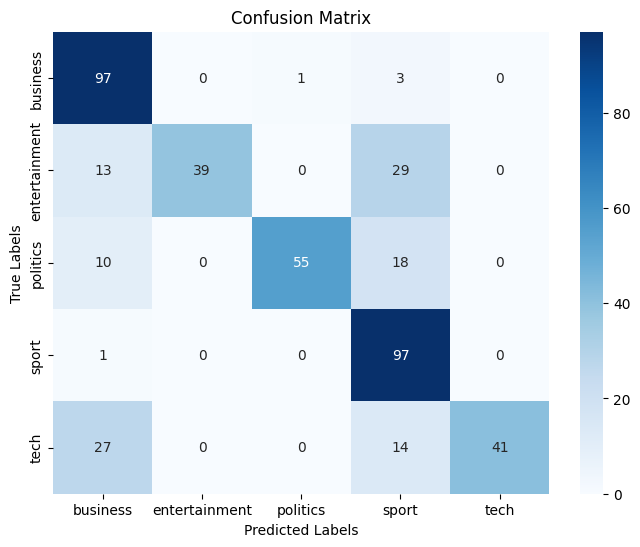

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Assuming y_test and y_pred are defined from your previous code
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

**5. Klasikasi Berita menggunakan RNN**

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3522 - loss: 1.5854 - val_accuracy: 0.6039 - val_loss: 1.1971
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5855 - loss: 1.0750 - val_accuracy: 0.8652 - val_loss: 0.6436
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8980 - loss: 0.5698 - val_accuracy: 0.9185 - val_loss: 0.3712
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9414 - loss: 0.2671 - val_accuracy: 0.9101 - val_loss: 0.3246
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9476 - loss: 0.2187 - val_accuracy: 0.9438 - val_loss: 0.2238
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9762 - loss: 0.1154 - val_accuracy: 0.9242 - val_loss: 0.2701
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9827 - loss: 0.1074 - val_accuracy: 0.9607 - val_loss: 0.1672
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9943 - loss: 0.0510 - val_accuracy: 0.9663 - val_loss: 0.1542
Epo

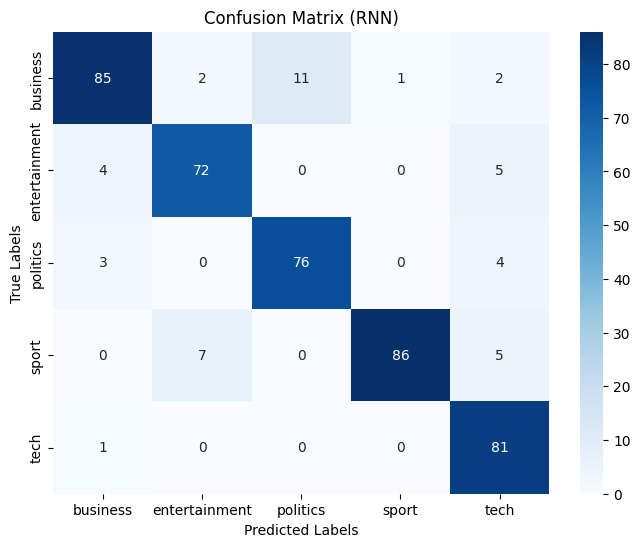

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi teks
tokenizer = Tokenizer(num_words=1000) # Sesuaikan num_words sesuai kebutuhan
tokenizer.fit_on_texts(X_train['text'])
X_train_seq = tokenizer.texts_to_sequences(X_train['text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['text'])

# Padding sequence
max_length = max(len(seq) for seq in X_train_seq) # Tentukan panjang maksimum sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# One-hot encode the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
num_classes = len(le.classes_)
y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

# Membuat model RNN
model = Sequential()
model.add(Embedding(1000, 128, input_length=max_length)) # Sesuaikan embedding dimension sesuai kebutuhan
model.add(LSTM(64)) # Sesuaikan units sesuai kebutuhan
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
model.fit(X_train_pad, y_train_onehot, epochs=10, batch_size=64, validation_split=0.2) # Sesuaikan epoch dan batch size

# Evaluasi model
loss, accuracy = model.evaluate(X_test_pad, y_test_onehot)
print('Test accuracy:', accuracy)

# Prediksi
y_pred_rnn = model.predict(X_test_pad)
y_pred_classes_rnn = np.argmax(y_pred_rnn, axis=1)

# Membuat classification report untuk RNN
print(classification_report(y_test_encoded, y_pred_classes_rnn, target_names=le.classes_))

# Confusion matrix
cm_rnn = confusion_matrix(y_test_encoded, y_pred_classes_rnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap="Blues",
xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (RNN)")
plt.show()

**6. Prediksi Berita menggunakan NBC**

In [ ]:
# prompt: prediksi berita menggunakan model nbc di atas

# Input text for prediction
input_text = "Barcelona suffered a surprise defeat at home to Leganes to see their lead at the top of La Liga cut. Hansi Flick's side are only above Atletico Madrid on goal difference and one point above third-placed Real Madrid. Leganes, who move up to 15th, took the lead in the fourth minute when Sergio Gonzalez headed in from Oscar Rodriguez's corner. That would prove to be the only goal of the game. Barcelona dominated, with 20 shots in total, and the closest they came was when Raphinha's half-volley from Alex Balde's cross hit the bar. Earlier on Sunday Atletico beat Getafe 1-0 to move level on points with Barcelona Champions Real drew 3-3 at Rayo Vallecano on Saturday." #@param {type:"string"}

# Preprocess the input text
processed_input = processCorpus([input_text], 'english')

# Transform the input text using TF-IDF
input_tfidf = tfidf_vectorizer.transform(processed_input)

# Reduce dimensions using SVD
input_svd = svd.transform(input_tfidf)

# Normalize the SVD features
input_svd = scaler.transform(input_svd)


# Make prediction using the trained Naive Bayes classifier
prediction = nb_classifier.predict(input_svd)

# Print the predicted category
print("Predicted Category:", prediction[0])

Predicted Category: sport


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


**7. Prediksi Berita menggunakan RNN**

In [ ]:
# prompt: prediksi berita menggunakan model rnn di atas

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Input text for prediction
input_text = "Barcelona suffered a surprise defeat at home to Leganes to see their lead at the top of La Liga cut. Hansi Flick's side are only above Atletico Madrid on goal difference and one point above third-placed Real Madrid. Leganes, who move up to 15th, took the lead in the fourth minute when Sergio Gonzalez headed in from Oscar Rodriguez's corner. That would prove to be the only goal of the game. Barcelona dominated, with 20 shots in total, and the closest they came was when Raphinha's half-volley from Alex Balde's cross hit the bar. Earlier on Sunday Atletico beat Getafe 1-0 to move level on points with Barcelona Champions Real drew 3-3 at Rayo Vallecano on Saturday." #@param {type:"string"}

# Preprocess the input text
processed_input = processCorpus([input_text], 'english')

# Tokenize and pad the input text
input_seq = tokenizer.texts_to_sequences(processed_input)
input_pad = pad_sequences(input_seq, maxlen=max_length)

# Make prediction using the trained RNN model
prediction_rnn = model.predict(input_pad)
predicted_class_rnn = np.argmax(prediction_rnn, axis=1)

# Get the predicted category using the LabelEncoder
predicted_category_rnn = le.inverse_transform(predicted_class_rnn)

# Print the predicted category
print("Predicted Category (RNN):", predicted_category_rnn[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted Category (RNN): sport


**Contoh Teks Berita untuk prediksi :**

**Teks 1 :** Barcelona suffered a surprise defeat at home to Leganes to see their lead at the top of La Liga cut. Hansi Flick's side are only above Atletico Madrid on goal difference and one point above third-placed Real Madrid. Leganes, who move up to 15th, took the lead in the fourth minute when Sergio Gonzalez headed in from Oscar Rodriguez's corner. That would prove to be the only goal of the game. Barcelona dominated, with 20 shots in total, and the closest they came was when Raphinha's half-volley from Alex Balde's cross hit the bar. Earlier on Sunday Atletico beat Getafe 1-0 to move level on points with Barcelona Champions Real drew 3-3 at Rayo Vallecano on Saturday.

Kategori : sport

link : [link text](https://www.bbc.com/sport/football/live/ckgn2n8kzqvt)



**Teks 2 :** Motorists under the influence of alcohol or drugs could be caught by a pioneering AI camera which is being tested for the first time in Devon and Cornwall. The state-of-the-art Heads-Up machine can detect road use and behaviour consistent with drivers who may be impaired by drink or drugs. Police further up the road can stop the vehicle, talk to the driver and do a roadside test for alcohol and illegal drugs. Geoff Collins, UK general manager of camera developer Acusensus, said: "We are delighted to be conducting the world's first trials of this technology right here in Devon and Cornwall. The camera can be moved quickly to any road in either county, without warning, with drivers unaware they have been spotted until police pull them over. "We are all safer if we can detect impairment before it causes an incident that could ruin lives," said Mr Collins. Acusensus cameras have previously been used to help police catch drivers using mobile phones at the wheel or not wearing seatbelts. With drink-drivers six times more likely to be involved in a fatal crash, Devon & Cornwall Police are hoping the Heads-Up system will help to save lives.

Kategori : Technology

Link : [link text](https://www.bbc.com/news/articles/cj0rqz003zdo)